In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from scipy.stats import entropy
from math import floor
import pandas
from tqdm.auto import tqdm
from pandas.tseries.offsets import MonthEnd
from sklearn.metrics.pairwise import euclidean_distances
import sys 
sys.path.append("/mnt/d/PHD/ISPRA_20152017_Analysis/modules/")
from plotting import * 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
from scipy.stats import kruskal 
from scikit_posthocs import posthoc_dunn
from scipy import stats 

In [2]:
def discrete_colormap(z : list, n_colors : int = None, palette_name : str = "jet"):
    
    z_min, z_max = min(z), max(z)
    if n_colors is None: 
        n_colors = len(np.unique(z))
    cm = cmaps.get_cmap(palette_name).resampled(n_colors)
     #cm = plt.cm.get_cmap(palette_name, n_colors)
    bounds = np.linspace(z_min, z_max, n_colors)
    norm = mpl.colors.BoundaryNorm(bounds, n_colors)

    return cm, bounds, norm
def plot_italian_coast(ax, xs : list[object] , ys : list[object], **kargs): 
    
    x_max = -np.inf
    x_min = np.inf
    y_max = -np.inf
    y_min = np.inf
    for x, y in zip(xs, ys): 
        x_max = max(x) if max(x) > x_max else x_max
        x_min = min(x) if min(x) < x_min else x_min
        y_max = max(y) if max(y) > y_max else y_max
        y_min = min(y) if min(y) < y_min else y_min
        ax.plot(x, y, 2, c = 'k', **kargs)
    ax.set_xlim(x_min * 0.99, x_max * 1.01)
    ax.set_ylim(y_min * 0.99, y_max * 1.01)

    return ax 
def group_and_order_abundance_species(df : pd.DataFrame, groupby_columns : list[object], taxon_column: str, numeric_column : str): 
    df = df.groupby(groupby_columns + [taxon_column]).mean()
    df = df.groupby(level = groupby_columns, group_keys=False).apply(lambda x: x.sort_values([numeric_column], ascending=False))
    return df
def select_threshold(group, q : float ): 
    cumsum = group.cumsum() / group.sum()
    idx = np.sum(cumsum.to_numpy() < q) + 1
    return group.iloc[:idx]
def find_most_representative_species(df : pd.DataFrame, groupby_columns : list[object], taxon_column : str, numeric_column : str, threshold : float = 0.9, n_greates = None, relative_abundance : bool = True): 
    df_ordered = group_and_order_abundance_species(df, groupby_columns, taxon_column, numeric_column)
    
    if relative_abundance: 
        df_ordered = df_ordered.groupby(groupby_columns, group_keys=False).apply(lambda x: x / x.sum())
        
    if n_greates: 
        if threshold: 
            raise ValueError("threshold and n_greates can not be simultaneously specified!")
        return df_ordered.groupby(groupby_columns, group_keys=False).head(n_greates)
    elif threshold: 
        return df_ordered.groupby(groupby_columns, group_keys=False).apply(select_threshold, threshold)
    else: 
        raise ValueError("Either n_greates or threshold must be set!")
def find_outliers(df : pd.DataFrame, column : str = None, index : str = None):
    if column: 
        df_slice = df.loc[:, column]
    elif index: 
        df_slice = df.loc[index]
    else: 
        df_slice = df
        
    Q1 = df_slice.quantile(0.25)
    Q3 = df_slice.quantile(0.75)
    IQR = Q3 - Q1
    return df_slice[~df_slice.between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR, inclusive="both")].dropna()
def IndVal(data : pd.DataFrame): 
    specificity =  data.groupby(level = data.index.names[0]).mean().apply(lambda x: x / x.sum())
    fidelity = data.groupby(level = data.index.names[0]).apply(lambda x: x.astype(bool).sum() / len(x))
    return specificity * fidelity
def compare_histograms(
    dfs : list[pd.DataFrame],  
    variables : list[str], 
    sup_title : str=None, 
    titles : list[str]=None,
    legend_labels : list[str]=None,
    x_labels : list[str]=None,
    y_labels : list[str]="Relative frequency",
    n_bins : int = 50,
    **kwargs
): 
    if "figsize" in kwargs: 
        figsize_dims = kwargs["figsize"]
    else: 
        figsize_dims = (8,8) if len(variables) == 1 else (8,13)
        
    if len(variables) == 1: 
        fig, axs = plt.subplots(1,1, figsize=figsize_dims)
    else : 
        n_rows = len(variables) // 2 
        fig, axs = plt.subplots(n_rows,2, figsize=figsize_dims)
        axs = axs.flat
    
    if sup_title: 
        plt.suptitle(sup_title)
        
    for ax, var, title, x_label, y_label in zip(fig.axes, variables, titles, x_labels, y_labels):
        right_edge = -np.inf
        left_edge = np.inf
        datas = [df[var].dropna().to_numpy() for df in dfs]
        for data in datas:
            right_edge = data.max() if right_edge < data.max() else right_edge
            left_edge = data.min() if left_edge > data.min() else left_edge
            
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        for data, label in zip(datas, legend_labels): 
            ax.hist(data, 
                    bins=np.linspace(left_edge,right_edge, n_bins, endpoint=True), 
                    alpha=0.5, 
                    weights=np.ones_like(data) / len(data),
                    label=label)
            ax.legend()
        
        fig.tight_layout()
def make_simplified_dataset(phyto_abundances : pd.DataFrame, MAX_DEPTH : float == 0.7): 
    phyto_abundances_simplified = phyto_abundances.loc[phyto_abundances["Sample_depth"] <= MAX_DEPTH, ["Region", "id", "Longitude", "Latitude", "Date", "Sample_depth", "Taxon", "Num_cell_l"]].copy()
    phyto_abundances_simplified["Genus"] = phyto_abundances_simplified["Taxon"].apply(lambda x: x.split(" ", maxsplit = 1)[0])
    phyto_abundances_simplified = phyto_abundances_simplified[["Region", "id", "Longitude",	"Latitude", "Date", "Sample_depth", "Genus", "Taxon", "Num_cell_l"]]
    #sometimes a reagion sampled more than once at the same depth
    return phyto_abundances_simplified.groupby(["Region", "id", "Longitude", "Latitude", "Date", "Sample_depth", "Genus", "Taxon"]).mean().reset_index()

In [3]:
phyto_abundances = pd.read_csv("/mnt/d/PHD/MSFD/Data/Modulo1/phyto_abund_modified.csv")
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [4]:
phyto_abund_simplified = make_simplified_dataset(phyto_abundances, 0.7)

In [5]:
best_path = [0,
 2,
 3,
 5,
 4,
 1,
 8,
 7,
 6,
 9,
 10,
 11,
 12,
 13,
 14,
 17,
 19,
 20,
 28,
 27,
 24,
 38,
 37,
 33,
 41,
 40,
 39,
 50,
 49,
 47,
 56,
 55,
 54,
 57,
 61,
 63,
 65,
 64,
 62,
 71,
 70,
 69,
 72,
 74,
 76,
 84,
 85,
 89,
 96,
 97,
 99,
 93,
 94,
 95,
 101,
 98,
 100,
 105,
 106,
 107,
 111,
 113,
 115,
 122,
 121,
 119,
 126,
 127,
 128,
 129,
 131,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 133,
 132,
 130,
 123,
 124,
 125,
 120,
 117,
 118,
 112,
 114,
 116,
 108,
 109,
 110,
 102,
 103,
 104,
 90,
 91,
 92,
 87,
 86,
 88,
 81,
 82,
 83,
 73,
 77,
 79,
 80,
 78,
 75,
 66,
 67,
 68,
 60,
 59,
 58,
 53,
 52,
 51,
 48,
 46,
 45,
 43,
 42,
 44,
 36,
 35,
 34,
 29,
 31,
 32,
 18,
 22,
 26,
 21,
 16,
 15,
 30,
 25,
 23]
best_path_sard = [1, 4, 5, 6, 7, 8, 12, 13, 14, 19, 16, 15, 20, 18, 17, 10, 11, 9, 0, 2, 3]
sea_index = {"Adriatic" : [0,45],
"Ionian" : [46, 69],
"Sicilian" : [70, 87],
"Tyrrhenian" : [88, 129],
"Ligurian" : [130,141],
"Sardinian" : [142, 161]
}
sea_index_array = np.array(list(sea_index.values()))
df = phyto_abundances.sort_values(by = "Latitude", ascending=False).drop_duplicates(subset = "id")[["Longitude", "Latitude", "Region", "id"]]
df.drop(df[df["Region"] == "Sardegna"].index, inplace = True)
df = df.reset_index(drop=True).reindex(best_path);
df_sard = phyto_abundances.sort_values(by = "Latitude", ascending=False).drop_duplicates(subset = "id")[["Longitude", "Latitude", "Region", "id"]]
df_sard = df_sard[df_sard["Region"] == "Sardegna"][["Longitude", "Latitude", "Region", "id"]]
df_sard = df_sard.reset_index(drop=True).reindex(best_path_sard);
df_id_ordered = pd.concat([df, df_sard], ignore_index=True)
id_ordered = df_id_ordered["id"].to_numpy()
del df, df_sard, df_id_ordered
ordered_regions = ["Friuli-Venezia-Giulia", 
 "Veneto", 
 "Emilia-Romagna", 
 "Marche",
 "Abruzzo", 
 "Molise",
 "Puglia",
 "Basilicata",
 "Calabria", 
 "Campania",
 "Lazio", 
 "Toscana",
 "Liguria", 
 "Sicilia",
 "Sardegna",
 ]
ordered_regions_dict = {region : order for order, region in enumerate(ordered_regions)}

## Contribution to the abundance for each cathegory

In [ ]:
phyto_abund_category = phyto_abund_simplified.drop(columns="Sample_depth")
phyto_abund_category.loc[phyto_abund_category["Genus"] == "Other", "Det_level"] = "Unknown"
phyto_abund_category.loc[phyto_abund_category["Taxon"].str.contains("indet") & ~phyto_abund_category["Taxon"].str.contains("Other"), "Det_level"] = "higher cat."
phyto_abund_category.loc[phyto_abund_category["Taxon"].str.contains("spp."), "Det_level"] = "Genus"
phyto_abund_category.loc[phyto_abund_category["Det_level"].isna(), "Det_level"] = "Species"

## barplot 

/tmp/ipykernel_11113/1305264679.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45);


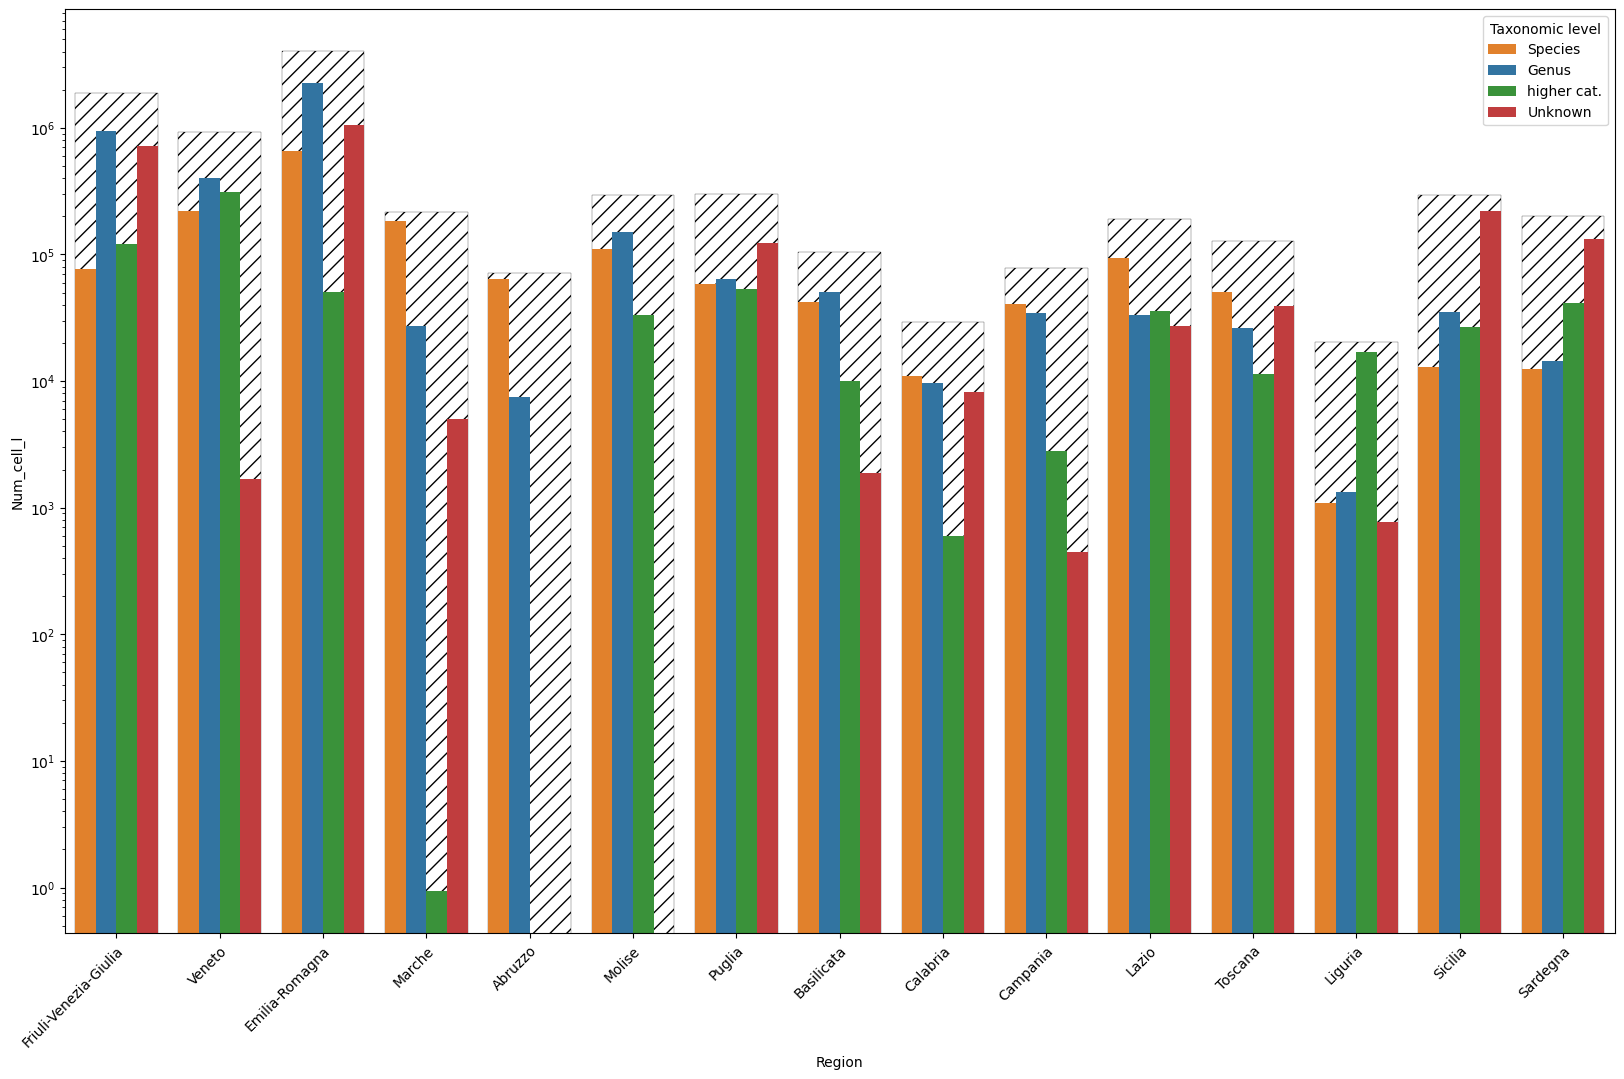

In [10]:
colours = {'Genus': 'C0', 'Species': 'C1', 'Unknown': 'C3', 'higher cat.': 'C2'}
ordered_cat = {"Species" : 0, "Genus" : 1, "higher cat." : 2, "Unknown" : 3}
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
df = phyto_abund_category.groupby(["Region", "Det_level"]).agg({"Num_cell_l" : "sum", "Taxon" : "nunique"}).reset_index()
samples = phyto_abund_category[["Region", "id", "Date"]].groupby(["Region", "id"]).nunique().reset_index().groupby("Region").sum(numeric_only=True).rename(columns={"Date" : "Num_cell_l"})
df["Num_cell_l"] = df[["Region", "Num_cell_l"]].set_index("Region").div(samples).loc[:, "Num_cell_l"].to_numpy()
df["Region"] = pd.Categorical(df["Region"], ordered=True, categories=ordered_regions)
df["Det_level"] = pd.Categorical(df["Det_level"], ordered=True, categories=ordered_cat.keys())
df.rename(columns={"Det_level" : "Taxonomic level"}, inplace=True)
bars = sns.barplot(df.groupby("Region").sum(numeric_only=True).reset_index(), x = "Region", y = "Num_cell_l", ax = ax, color= "white", width = 0.8, linewidth = 0.2, edgecolor = "k")
for bar in bars.patches: 
    bar.set_hatch("//")
sns.barplot(df, x="Region", y="Num_cell_l", hue = "Taxonomic level", palette = colours, ax = ax, width = 0.8)
ax.set_yscale("log")
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45);

/tmp/ipykernel_11113/3531750725.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45);


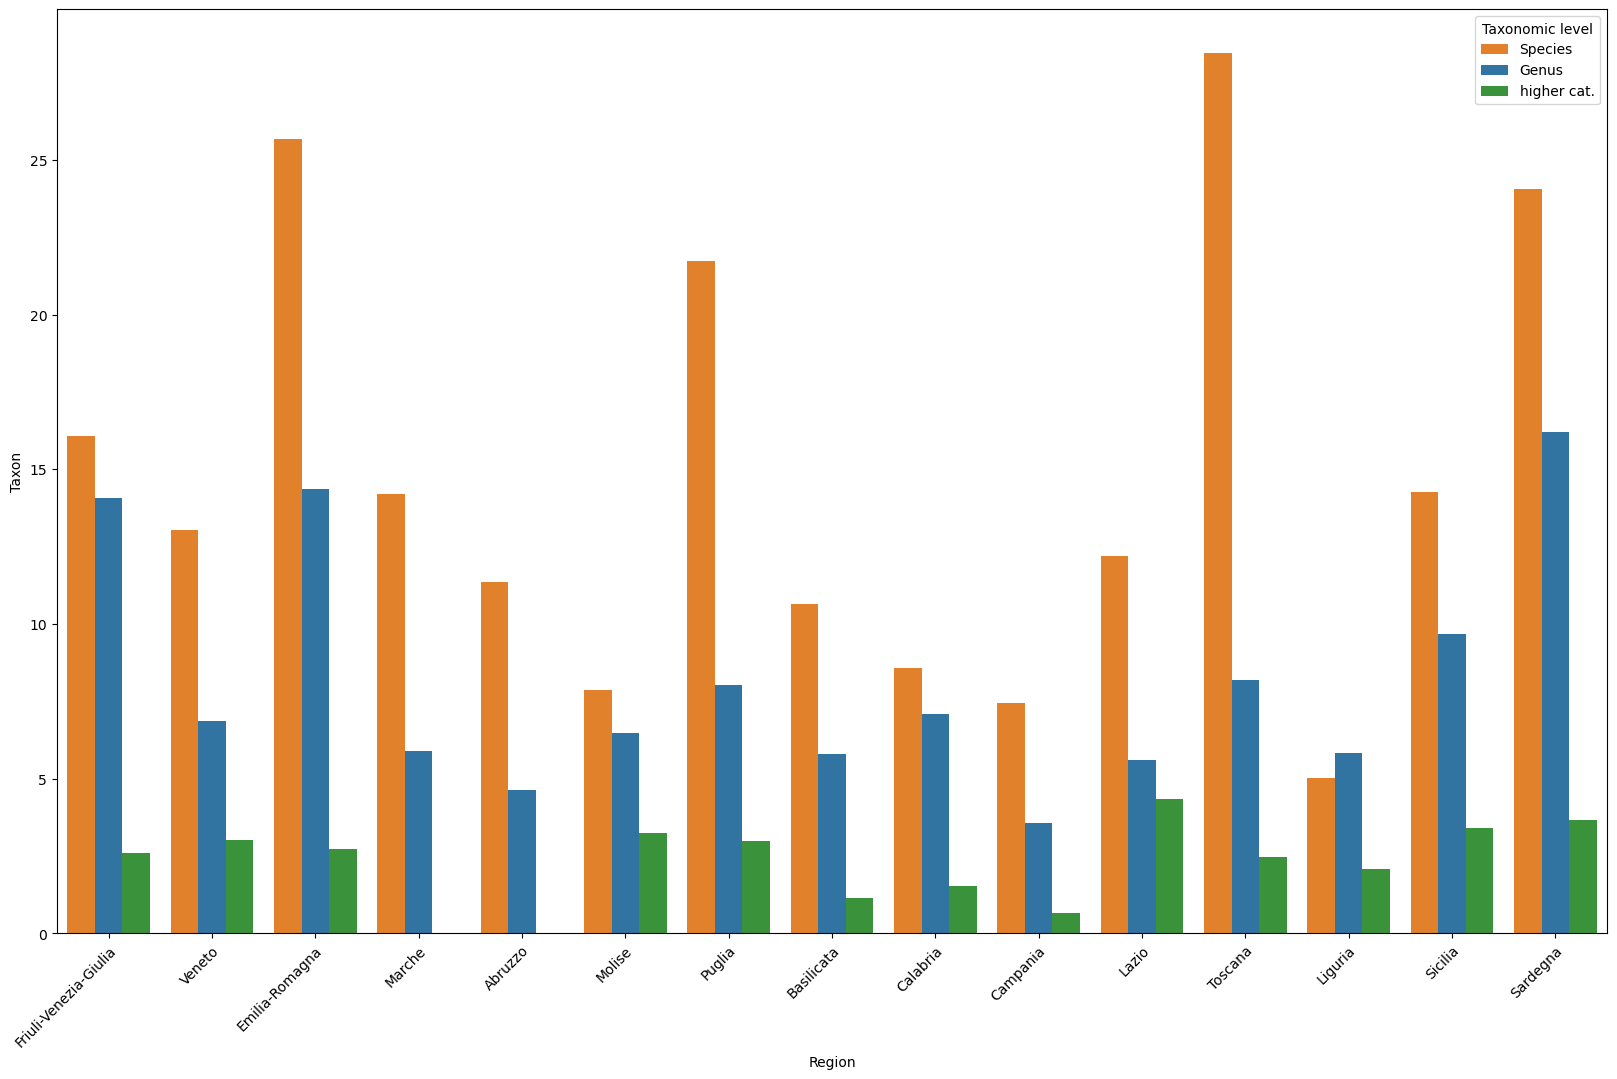

In [11]:
colours = {'Genus': 'C0', 'Species': 'C1', 'higher cat.': 'C2'}
ordered_cat = {"Species" : 0, "Genus" : 1, "higher cat." : 2}
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
df = phyto_abund_category.groupby(["Region", "Det_level"]).agg({"Num_cell_l" : "sum", "Taxon" : "count"}).reset_index()
df = df.loc[df["Det_level"] != "Unknown", :] 
samples = phyto_abund_category[["Region", "id", "Date"]].groupby(["Region", "id"]).nunique().reset_index().groupby("Region").sum(numeric_only=True).rename(columns={"Date" : "Taxon"})
df["Taxon"] = df[["Region", "Taxon"]].set_index("Region").div(samples).loc[:, "Taxon"].to_numpy()
df["Det_level"] = pd.Categorical(df["Det_level"], ordered=True, categories=ordered_cat.keys())
df.rename(columns={"Det_level" : "Taxonomic level"}, inplace=True)
df["Region"] = pd.Categorical(df["Region"], ordered=True, categories=ordered_regions)
sns.barplot(df, x="Region", y="Taxon", hue = "Taxonomic level", palette = colours, ax = ax, width = 0.8)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45);

/tmp/ipykernel_11113/3819911525.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45);


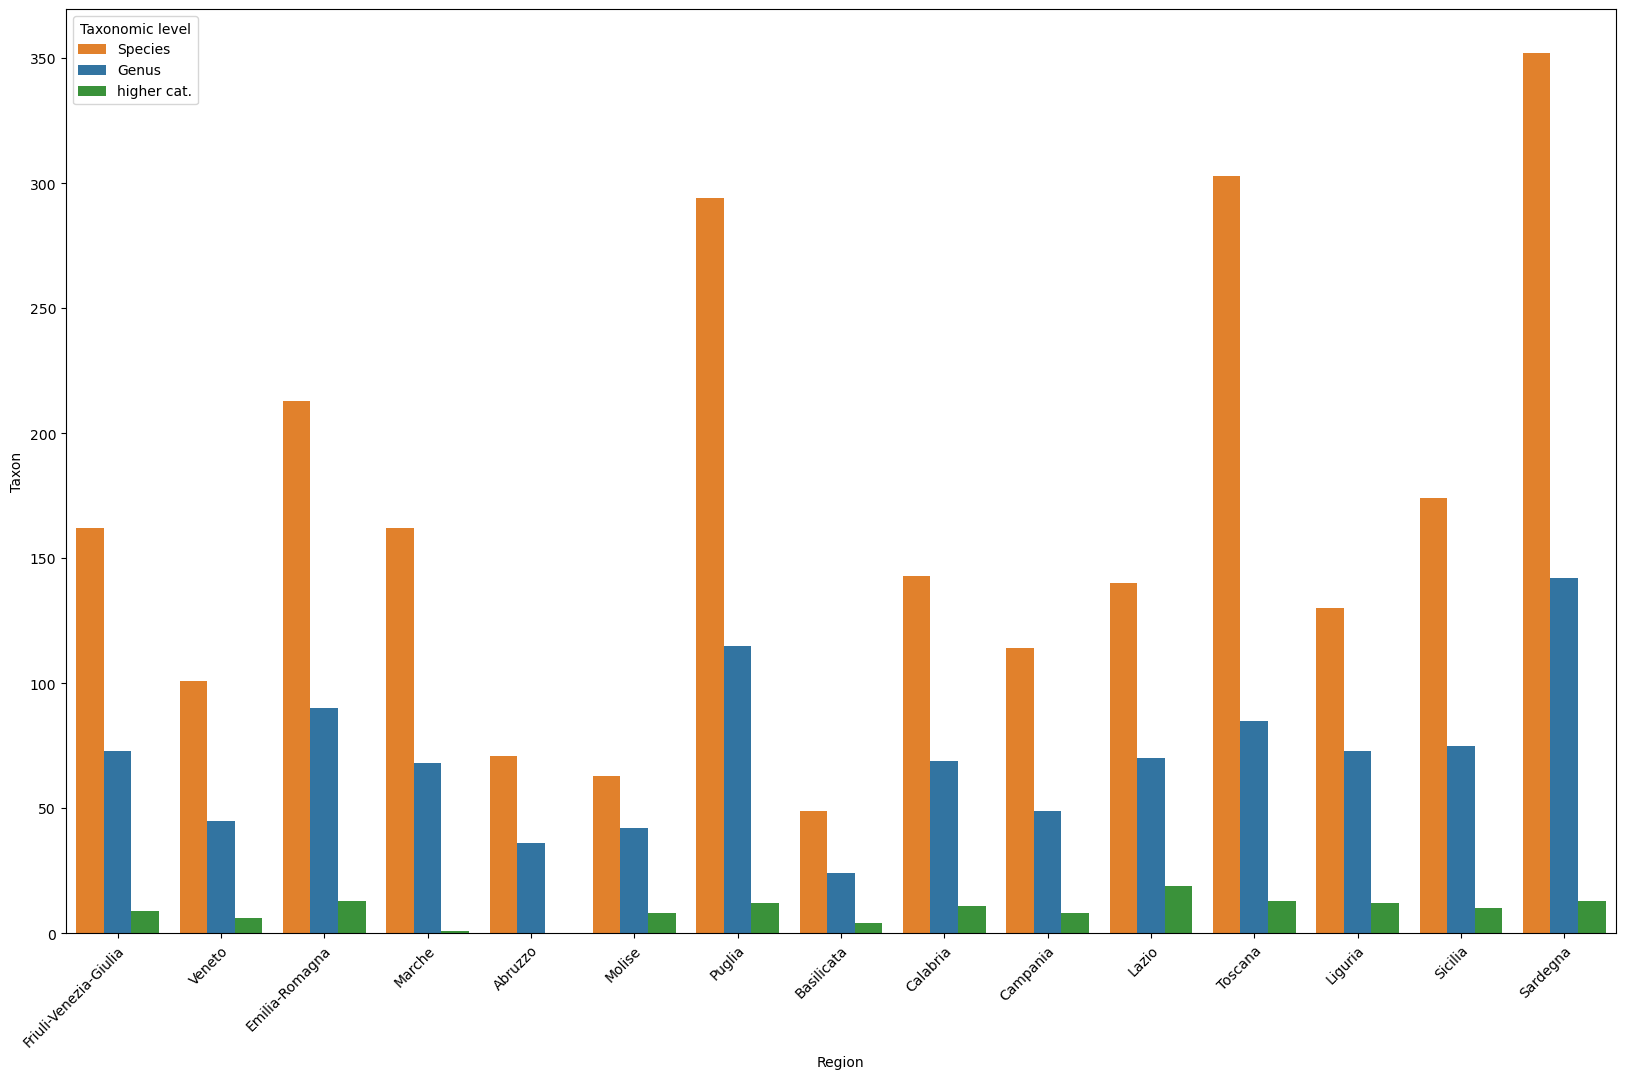

In [12]:
colours = {'Genus': 'C0', 'Species': 'C1', 'higher cat.': 'C2'}
ordered_cat = {"Species" : 0, "Genus" : 1, "higher cat." : 2}
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
df = phyto_abund_category.groupby(["Region", "Det_level"]).agg({"Num_cell_l" : "sum", "Taxon" : "nunique"}).reset_index()
df = df.loc[df["Det_level"] != "Unknown", :] 
df["Det_level"] = pd.Categorical(df["Det_level"], ordered=True, categories=ordered_cat.keys())
df.rename(columns={"Det_level" : "Taxonomic level"}, inplace=True)
df["Region"] = pd.Categorical(df["Region"], ordered=True, categories=ordered_regions)
sns.barplot(df, x="Region", y="Taxon", hue = "Taxonomic level", palette = colours, ax = ax, width = 0.8)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45);

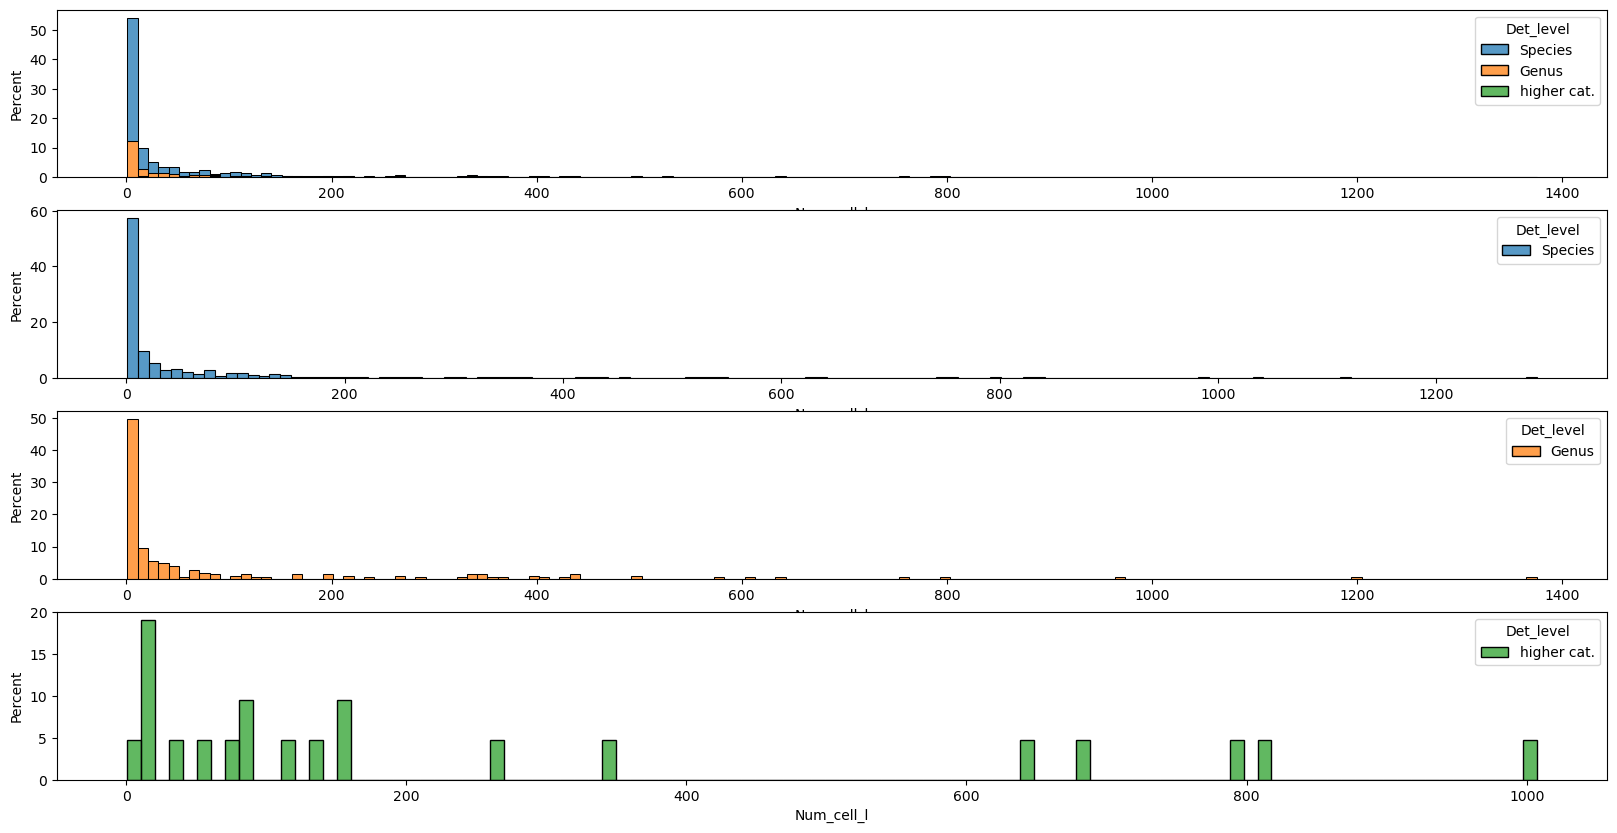

In [8]:
colours = {'Genus': 'C1', 'Species': 'C0', 'Unknown': 'C3', 'higher cat.': 'C2'}
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
axs = axs.flatten()
sns.histplot(phyto_abund_category.loc[phyto_abund_category["Det_level"] != "Unknown", ["Taxon", "Num_cell_l", "Det_level"]].groupby(["Det_level", "Taxon"]).count().reset_index().sort_values(by = "Num_cell_l"), x = "Num_cell_l", hue = "Det_level", stat="percent", binwidth=10, multiple="stack", ax = axs[0])
for ax, level, col in zip(axs[1:], ["Species", "Genus", "higher cat."], ["C0", "C1", "C2"]):
     sns.histplot(phyto_abund_category.loc[phyto_abund_category["Det_level"] == level, ["Taxon", "Num_cell_l", "Det_level"]].groupby(["Det_level", "Taxon"]).count().reset_index().sort_values(by = "Num_cell_l"), x = "Num_cell_l", hue = "Det_level", stat="percent", binwidth=10, multiple="stack", ax = ax, palette=colours)

NameError: name 'phyto_abund_category' is not defined

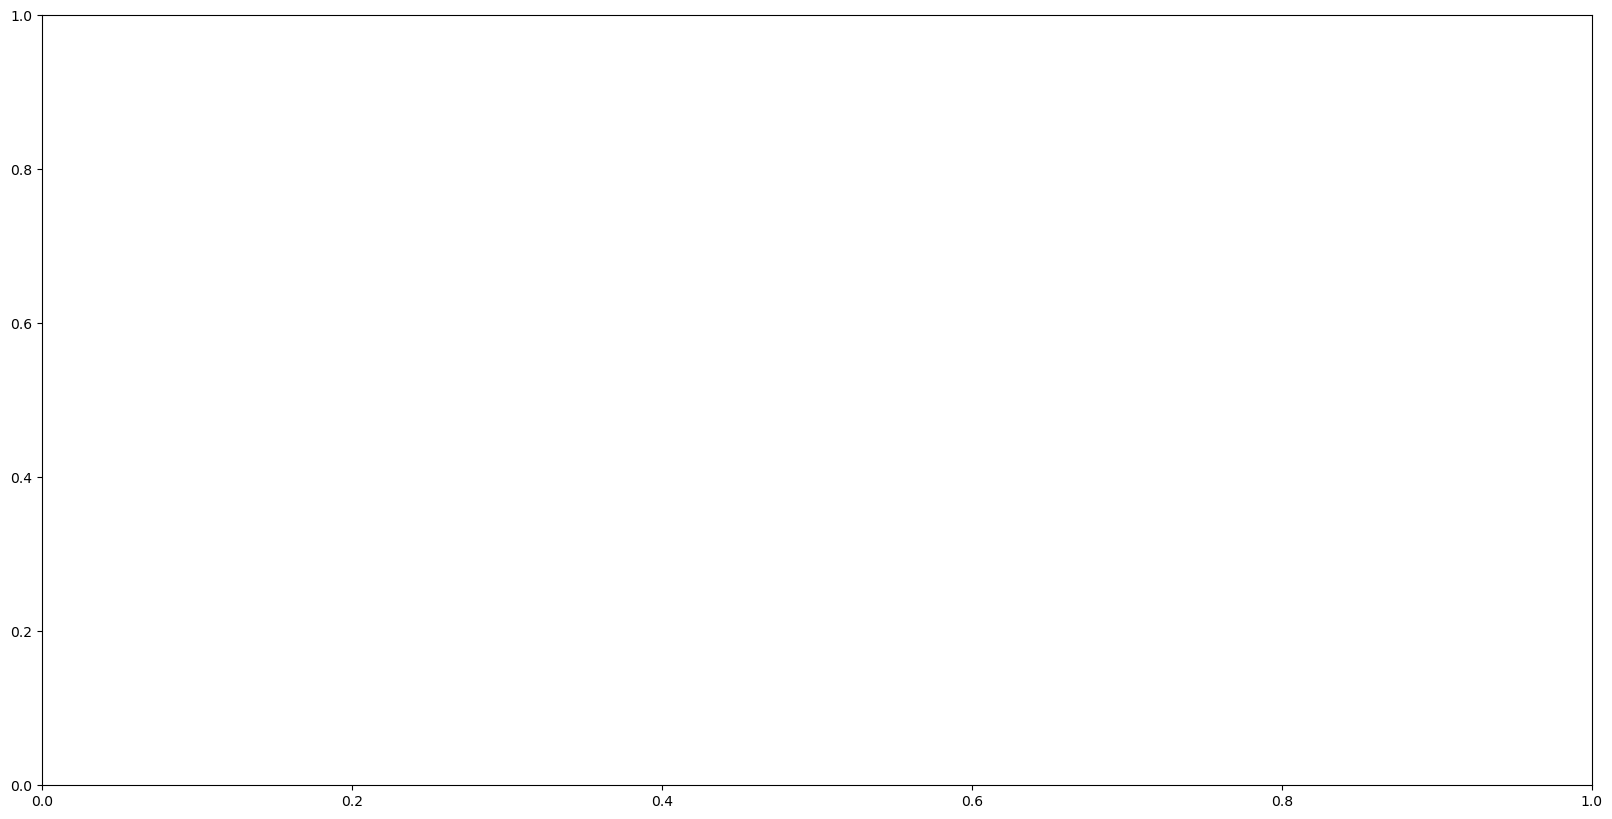

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df = phyto_abund_category.copy()
#df["Num_cell_l"] = df["Num_cell_l"].apply(np.log)
sns.histplot(df, x = "Num_cell_l", ax = ax, log_scale=[False, True])
#ax.set_xscale("log")